# Bootcalib code for z camera

In [1]:
%matplotlib inline

In [2]:
# imports
try:
    import seaborn as sns; sns.set(context="notebook",font_scale=2)
except:
    pass

from desispec import bootcalib as desiboot
from desiutil import funcfits as dufits
from astropy.io import fits
from astropy.stats import sigma_clip

import numpy as np
from astropy.modeling import models, fitting

/Users/xavier/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Flat tracing

### Read flat

In [3]:
fiberflat = '/Users/xavier/DESI/Wavelengths/pix-z0-00000001.fits'
flat_hdu = fits.open(fiberflat)
header = flat_hdu[0].header
flat = flat_hdu[0].data
ny = flat.shape[0]

### Find fibers

In [4]:
xpk, ypos, cut = desiboot.find_fiber_peaks(flat)

INFO:bootcalib.py:684:find_fiber_peaks: starting


INFO:DESI:starting


INFO:bootcalib.py:721:find_fiber_peaks: Found 500 fibers


INFO:DESI:Found 500 fibers


INFO:bootcalib.py:729:find_fiber_peaks: Found 20 bundles


INFO:DESI:Found 20 bundles


In [5]:
tst = True
if tst:
    xpk = xpk[0:5]

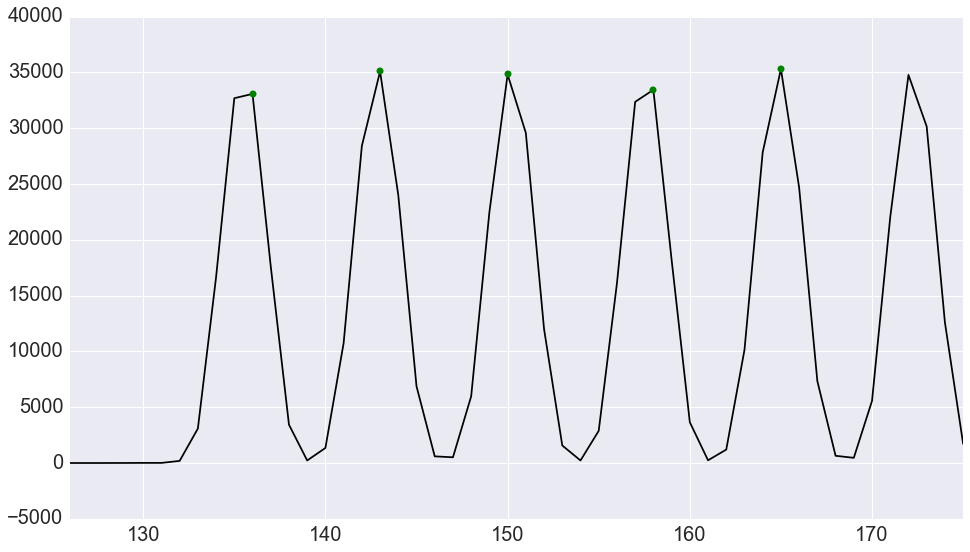

In [6]:
reload(desiboot)
desiboot.qa_fiber_peaks(xpk, cut)

### Trace the fiber flat spectra

In [7]:
# Crude first
xset, xerr = desiboot.trace_crude_init(flat,xpk,ypos)
# Polynomial fits
xfit, fdicts = desiboot.fit_traces(xset,xerr)

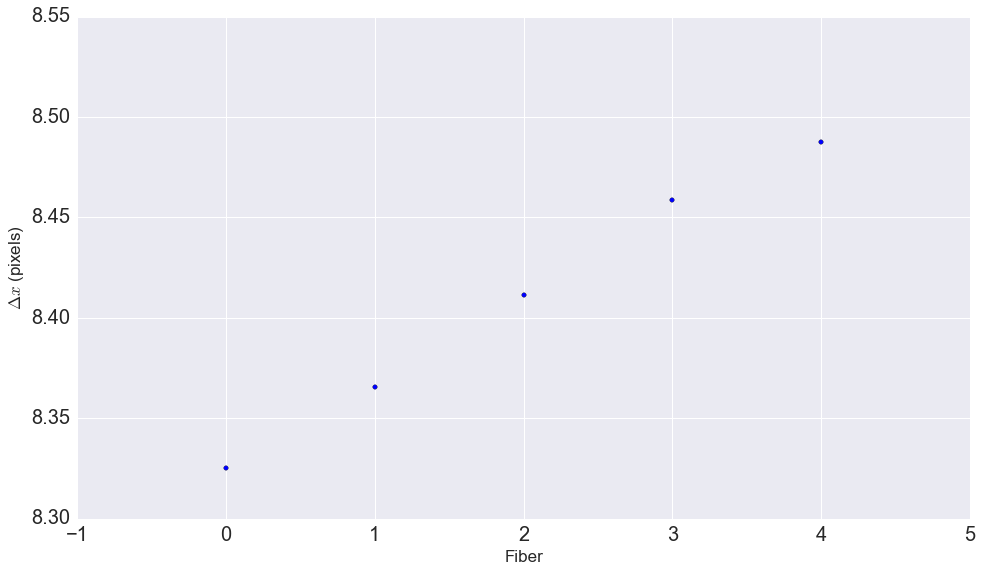

In [8]:
# QA
desiboot.qa_fiber_Dx(xfit, fdicts)

### Model the PSF with Gaussian

In [9]:
gauss = desiboot.fiber_gauss(flat,xfit,xerr)

INFO:bootcalib.py:606:fiber_gauss: Working on fiber 0 of 5


INFO:DESI:Working on fiber 0 of 5


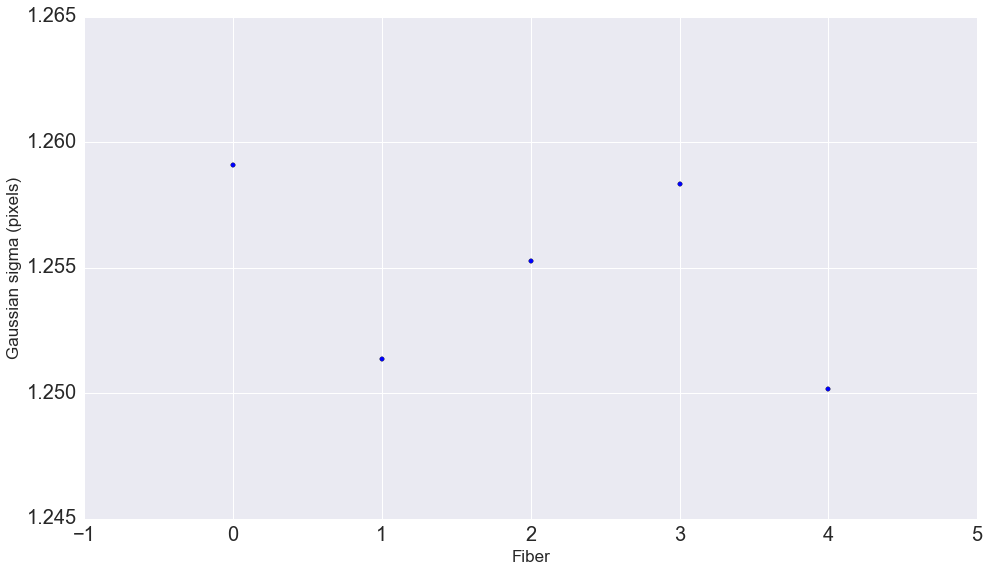

In [10]:
reload(desiboot)
desiboot.qa_fiber_gauss(gauss)

## Arc

### Wavelength info

In [11]:
import desimodel.io

In [12]:
desi_psf = desimodel.io.load_psf('z')

In [13]:
wave4 = desi_psf.wavelength(4,np.arange(desi_psf.npix_y))

In [14]:
np.min(wave4), np.max(wave4)

(7363.2868516678909, 9835.6518691435376)

In [15]:
for pix in [1606.8,1800.4,1958.76,2030.1,2063.3,3212.157]:
    print("{:f}, {:f}".format(pix,wave4[int(pix)]))

1606.800000, 8377.367519
1800.400000, 8495.621630
1958.760000, 8591.248165
2030.100000, 8634.615519
2063.300000, 8654.447639
3212.157000, 9326.342400


In [16]:
np.abs(wave4[0]-wave4[-1])/desi_psf.npix_y

0.59892563407840282

### Read arc

In [17]:
arcfile = '/Users/xavier/DESI/Wavelengths/pix-z0-00000000.fits'
arc_hdu = fits.open(arcfile)
arc = arc_hdu[0].data

### Extract arc

In [18]:
all_spec = desiboot.extract_sngfibers_gaussianpsf(arc,xfit,gauss,verbose=False)

### Linelist

In [19]:
reload(desiboot)
camera = header['CAMERA']
llist = desiboot.load_arcline_list(camera)
dlamb, wmark, gd_lines, line_guess = desiboot.load_gdarc_lines(camera)

INFO:bootcalib.py:469:load_arcline_list: Rejecting select HgI lines


INFO:DESI:Rejecting select HgI lines


INFO:bootcalib.py:469:load_arcline_list: Rejecting select NeI lines


INFO:DESI:Rejecting select NeI lines


In [20]:
gd_lines

array([ 7438.898 ,  7488.8712,  7535.7739,  8136.4061,  8300.3248,
        8377.607 ,  8495.3591,  8591.2583,  8634.6472,  8654.3828,
        8783.7539,  9148.672 ,  9201.7588])

### Solve

In [21]:
ii=4

### Find Lines

In [22]:
spec = all_spec[:,ii]
# Find Lines
pixpk = desiboot.find_arc_lines(spec)

In [23]:
pixpk

array([  116.07717404,   167.94179402,   193.13964733,   265.81462323,
         278.63786872,   420.58812484,   905.86923243,  1128.54636301,
        1186.14138714,  1215.09766856,  1414.05598055,  1422.18759471,
        1480.32038878,  1587.25266218,  1606.32335587,  1673.06150512,
        1746.87786852,  1799.67640313,  1958.03562895,  2030.07941549,
        2050.65850082,  2062.90492529,  2104.98373459,  2108.74678951,
        2259.02328904,  2274.06227865,  2279.24403849,  2397.65219205,
        2417.22505069,  2508.83525188,  2901.91513773,  2994.12627577,
        3025.95656923,  3167.16658989,  3212.15701257,  3386.52439237,
        3580.79260178,  3817.03691692])

In [24]:
#xdb.xplot(spec)

### Match a set of 5 gd_lines to detected lines

In [25]:
reload(desiboot)
id_dict = desiboot.id_arc_lines(pixpk,gd_lines,dlamb,wmark,line_guess=line_guess)#line_guess)

In [26]:
id_dict

{u'dlamb': 0.599,
 u'first_id_idx': [14, 17, 18, 19, 21],
 u'first_id_pix': array([ 1606.32335587,  1799.67640313,  1958.03562895,  2030.07941549,
         2062.90492529]),
 u'first_id_wave': array([ 8377.607 ,  8495.3591,  8591.2583,  8634.6472,  8654.3828]),
 u'fit': {'coeff': array([ -8.61539051e+03,   4.02297991e-01,   1.24028892e-05]),
  'func': u'polynomial',
  'order': 2,
  'xmax': 1.0,
  'xmin': 0.0},
 'guess': 18,
 u'icen': 7,
 'im1': 17,
 'im2': 14,
 'ip1': 19,
 'ip2': 21,
 'rms': 0.030627837743002002,
 u'wmark': 8591.2583}

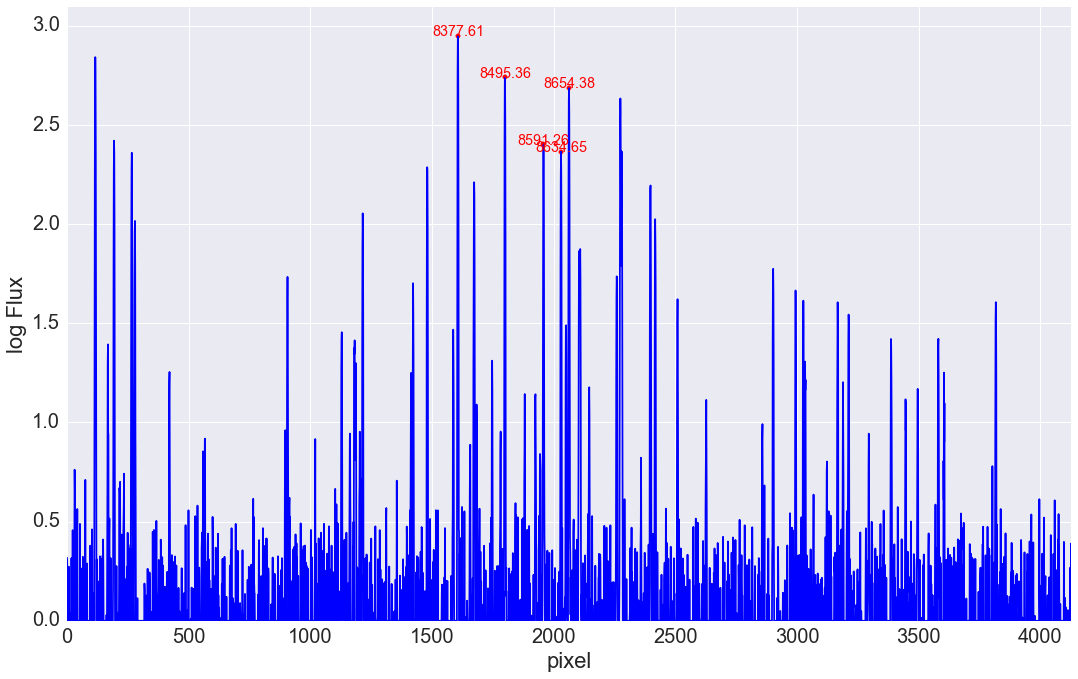

In [28]:
# IDs
plt.clf()
plt.figure(figsize=(18, 11))

yspec = np.log10(np.maximum(spec,1))
xpk = id_dict['first_id_pix']
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,xpixpk in enumerate(id_dict['first_id_pix']):
    plt.text(xpixpk, yspec[int(np.round(xpixpk))], '{:g}'.format(id_dict['first_id_wave'][jj]),
         ha='center',color='red',size='x-large')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
#plt.xlim(2650., 2750)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

### Find the other good ones

In [29]:
desiboot.add_gdarc_lines(id_dict, pixpk, gd_lines)

In [30]:
id_dict

{u'dlamb': 0.599,
 u'first_fit': {'coeff': array([ -8.61539051e+03,   4.02297991e-01,   1.24028892e-05]),
  'func': u'polynomial',
  'order': 2,
  'xmax': 1.0,
  'xmin': 0.0},
 u'first_id_idx': [14, 17, 18, 19, 21],
 u'first_id_pix': array([ 1606.32335587,  1799.67640313,  1958.03562895,  2030.07941549,
         2062.90492529]),
 u'first_id_wave': array([ 8377.607 ,  8495.3591,  8591.2583,  8634.6472,  8654.3828]),
 u'fit': {'coeff': array([ -1.20415470e+04,   1.04028273e+00,  -2.70876091e-05,
           8.12741659e-10]),
  'func': u'polynomial',
  'order': 3,
  'xmax': 1.0,
  'xmin': 0.0},
 'guess': 18,
 u'icen': 7,
 u'id_idx': [3, 9, 12, 14, 17, 18, 19, 21, 26, 30, 31],
 u'id_pix': [265.81462323309972,
  1215.0976685584342,
  1480.3203887820016,
  1606.3233558708064,
  1799.6764031329424,
  1958.0356289482006,
  2030.0794154938301,
  2062.9049252873442,
  2279.2440384869547,
  2901.9151377314806,
  2994.1262757690824],
 u'id_wave': [7535.7739000000001,
  8136.4061000000002,
  8300.32

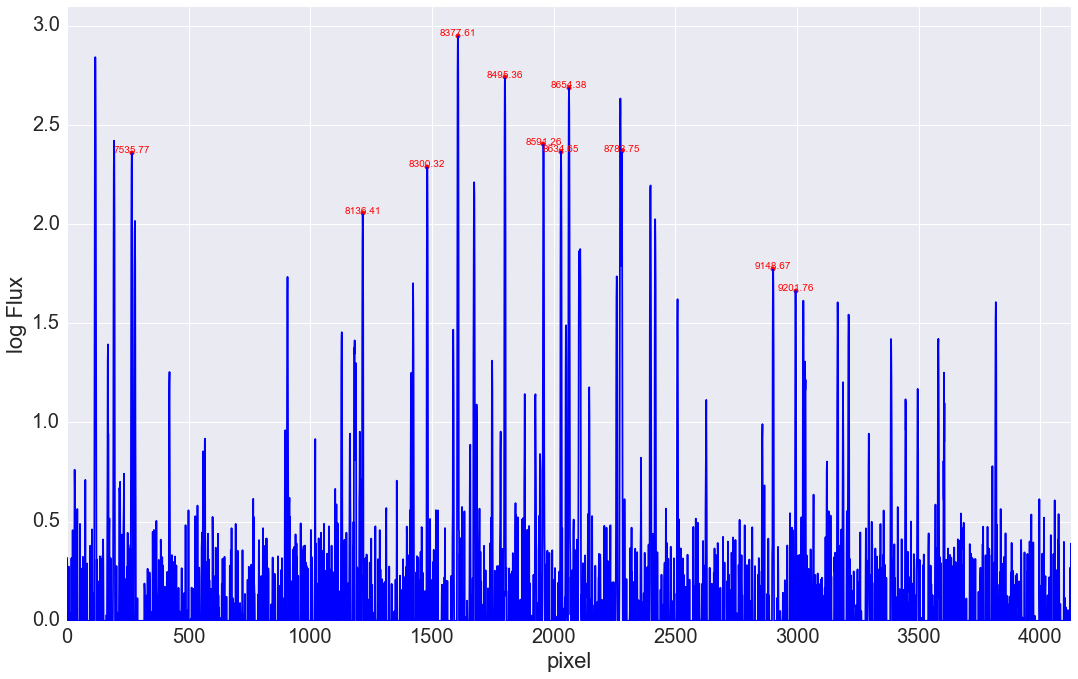

In [31]:
# IDs
plt.clf()
plt.figure(figsize=(18, 11))

yspec = np.log10(np.maximum(spec,1))
xpk = id_dict['id_pix']
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,xpixpk in enumerate(id_dict['id_pix']):
    plt.text(xpixpk, yspec[int(np.round(xpixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

### Now the rest

In [32]:
desiboot.id_remainder(id_dict, pixpk, llist)

In [33]:
id_dict['rms']

0.11072671658813787

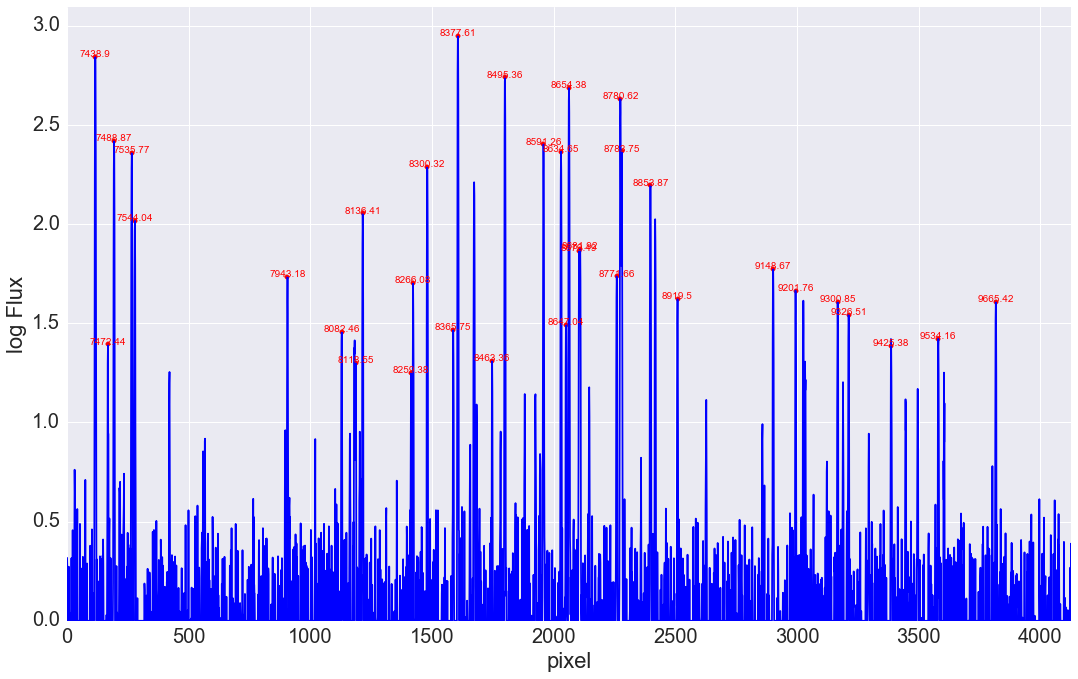

In [34]:
# IDs
plt.clf()
plt.figure(figsize=(18, 11))

yspec = np.log10(np.maximum(spec,1))
xpk = id_dict['id_pix']
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,xpixpk in enumerate(id_dict['id_pix']):
    plt.text(xpixpk, yspec[int(np.round(xpixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

### Final fit wave vs. pix too

In [35]:
final_fit, mask = dufits.iter_fit(np.array(id_dict['id_wave']), np.array(id_dict['id_pix']), 'polynomial', 3, xmin=0., xmax=1.)
rms = np.sqrt(np.mean((dufits.func_val(np.array(id_dict['id_wave'])[mask==0], final_fit)-np.array(id_dict['id_pix'])[mask==0])**2))
final_fit_pix,mask2 = dufits.iter_fit(np.array(id_dict['id_pix']), np.array(id_dict['id_wave']),'legendre',4, niter=5) 

In [36]:
print("RMS = {:g}".format(rms))

RMS = 0.214326
